# Inference with sampling for flu data

## Flu case incidences

In [21]:
import numpy as np
import pandas as pd

import seirmo as se
from seirmo import plots

# read french flu data
flu_data = se.DatasetLibrary().french_flu()

# extract data of roughly one season (estimated)
flu_data = flu_data.loc[:30,:]
times = flu_data['time_index']

# normalise incidence number by its maximum
flu_data['inc'] = flu_data['inc'] / np.max(flu_data['inc'])

In [22]:
# Plot incidences data
plot = plots.IncidenceNumberPlot()
plot.add_data(flu_data, time_key='time_index', inc_key='inc')
plot.show()

# Using pints

In [23]:
import pints

class SEIRModel(pints.ForwardModel):
    def __init__(self):
        super(SEIRModel, self).__init__()

        self._model = se.SEIRModel()
    
    def n_outputs(self):
        # Returns number of model outputs.
        # Returns only incidence number, in line with the flu data
        return 1

    def n_parameters(self):
        # Returns number of parameters, i.e. 4 initial condition and 3 parameters.
        return 7
    
    def simulate(self, log_parameters, times):
        # parameters = np.exp(log_parameters)
        output = self._model.simulate(parameters=parameters, times=times, return_incidence=True)
        n_incidence = output[:,4]

        return n_incidence

In [47]:
# Create log-likelihood
pints_model = SEIRModel()
problem = pints.SingleOutputProblem(pints_model, times, flu_data['inc'])
log_likelihood = pints.GaussianLogLikelihood(problem)

In [48]:
log_prior = pints.UniformLogPrior(
    # [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
    [0, 0, 0, 0, 0, 0, 0, 0.01],
    [1, 1, 1, 1, 1, 1, 1, 1]
)

In [49]:
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [57]:
# initial parameter guess
parameter_guess = np.array([0.7, 0, 0.3, 0, 0.5, 0.5, 0.1, 0.1])

In [58]:
xs = [
    parameter_guess * 0.9,
    parameter_guess * 1.05,
    parameter_guess * 1.15,
]

In [59]:
# parameter transformation
# transform = pints.LogTransformation(n_parameters=8)
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioACMC)

# mcmc.set_max_iterations(4000)

chains = mcmc.run()

3.8
2200  6603   0.214     0.198     0.204      0:13.9
2220  6663   0.214     0.199     0.204      0:14.0
2240  6723   0.213     0.198     0.206      0:14.1
2260  6783   0.212     0.195931  0.207      0:14.2
2280  6843   0.213     0.196     0.208242   0:14.3
2300  6903   0.215     0.198     0.208      0:14.5
2320  6963   0.213     0.199483  0.207      0:14.6
2340  7023   0.212     0.202     0.206      0:14.7
2360  7083   0.212     0.202     0.205      0:14.8
2380  7143   0.212     0.205     0.206      0:15.0
2400  7203   0.213661  0.206     0.206      0:15.1
2420  7263   0.212722  0.206     0.207      0:15.3
2440  7323   0.213     0.206     0.208      0:15.4
2460  7383   0.211     0.206     0.208      0:15.5
2480  7443   0.212     0.206     0.207      0:15.6
2500  7503   0.212     0.206     0.209      0:15.7
2520  7563   0.212614  0.206     0.21       0:15.9
2540  7623   0.213     0.206218  0.21       0:16.0
2560  7683   0.212417  0.205779  0.209      0:16.1
2580  7743   0.212     0.20

# Pints' diagnostic plots

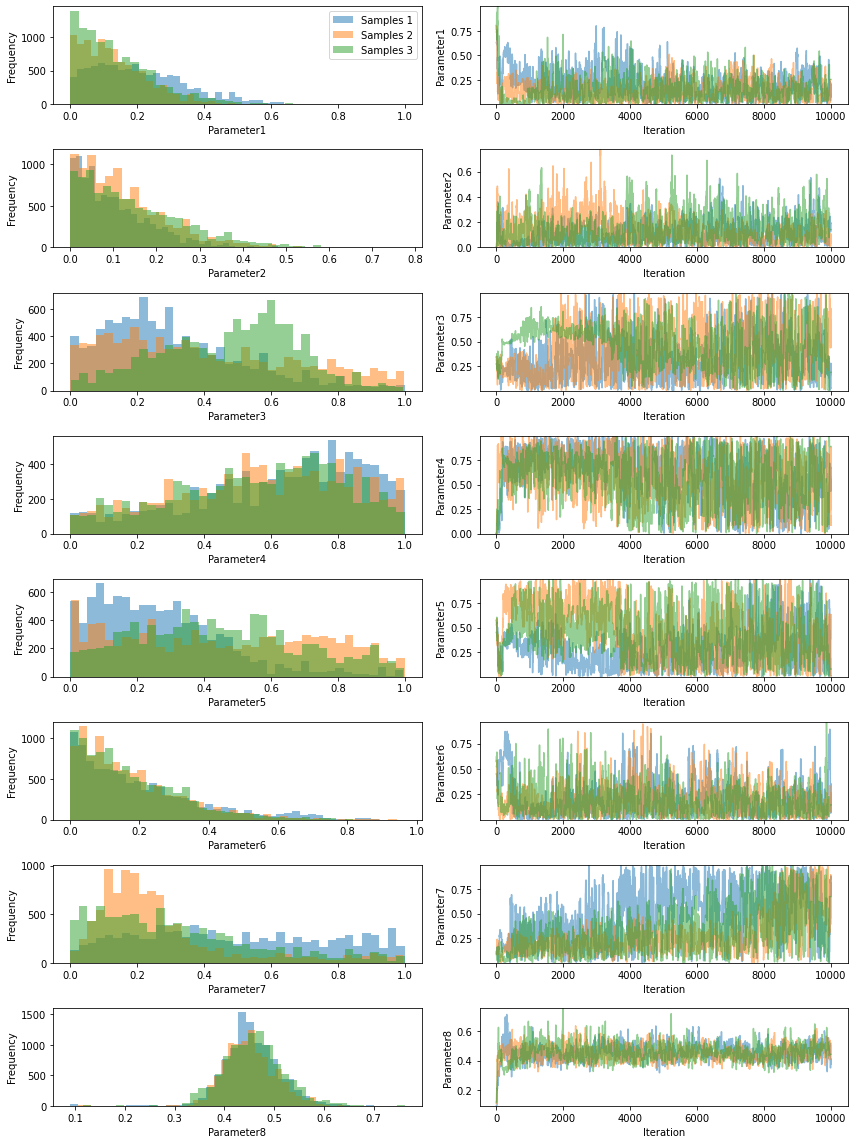

In [60]:
import pints.plot
import matplotlib.pyplot as plt

pints.plot.trace(chains)
plt.show()